# Data Preparation

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import datetime as dt
from sklearn import preprocessing
sns.set()
# https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [2]:
# Importing data
data = pd.read_csv("assets/Tetuan_City_power_consumption.csv" ) 
data.columns = data.columns.str.replace('  ','_').str.replace(' ','_')
data

,DateTime,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Zone_1_Power_Consumption,Zone_2_Power_Consumption,Zone_3_Power_Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DateTime                  52416 non-null  object 
 1   Temperature               52416 non-null  float64
 2   Humidity                  52416 non-null  float64
 3   Wind_Speed                52416 non-null  float64
 4   general_diffuse_flows     52416 non-null  float64
 5   diffuse_flows             52416 non-null  float64
 6   Zone_1_Power_Consumption  52416 non-null  float64
 7   Zone_2_Power_Consumption  52416 non-null  float64
 8   Zone_3_Power_Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [7]:
# Converting Datetime column to datetime data type and make it as index
data.DateTime = pd.to_datetime(data.DateTime)
data.set_index('DateTime', inplace=True)

In [8]:
data.describe()

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Zone_1_Power_Consumption,Zone_2_Power_Consumption,Zone_3_Power_Consumption
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360


- Tempreture is in range of [3, 40] with mean=18. It is north of Africa. Most of the power consumtion is used for cooling systems.<br><br>

- Data set contains three different zones (regoins of Tetuan city)
1.  Zone 1: Name of neighbourhood is Quads. It is residential with more population that the other two.
2.  Zone 2: Name of neighbourhood is Boussafou. It is residential with less population that the first zone.
3.  Zone 3: Name of neighbourhood is Smir. It is a beach area with hotels and spas. Power consumption has high variation during different month, however the average of consumption is lower than the other two.

<img src="assets/Tetuan_city_zones.png"  align="center"/>

# Zones

In [9]:
# Changing frequency of data to daily
data_zones = data[['Temperature', 'Zone_1_Power_Consumption', 'Zone_2_Power_Consumption', 'Zone_3_Power_Consumption']]
data_zones_daily = data_zones.resample('D').agg({'Temperature': np.mean, 
                                                 'Zone_1_Power_Consumption': np.sum, 
                                                 'Zone_2_Power_Consumption': np.sum,
                                                 'Zone_3_Power_Consumption': np.sum})
# Adding two columns, weekday and month
data_zones_daily['weekday'] = data_zones_daily.index.day_name()
data_zones_daily['month'] = data_zones_daily.index.month_name()
data_zones_daily

,Temperature,Zone_1_Power_Consumption,Zone_2_Power_Consumption,Zone_3_Power_Consumption,weekday,month
DateTime,,,,,,
2017-01-01,9.675299,4.098993e+06,2.554242e+06,2.573107e+06,Sunday,January
2017-01-02,12.476875,4.157207e+06,2.816312e+06,2.566190e+06,Monday,January
2017-01-03,12.100000,4.400992e+06,2.888247e+06,2.537396e+06,Tuesday,January
2017-01-04,10.509479,4.419336e+06,2.894699e+06,2.545012e+06,Wednesday,January
2017-01-05,10.866444,4.435619e+06,2.884888e+06,2.543641e+06,Thursday,January
...,...,...,...,...,...,...
2017-12-26,11.621840,4.321941e+06,3.565009e+06,1.640978e+06,Tuesday,December
2017-12-27,15.232917,4.315243e+06,3.608277e+06,1.655752e+06,Wednesday,December
2017-12-28,13.662361,4.358449e+06,3.540276e+06,1.608052e+06,Thursday,December


## Daily Energy Consumption plot

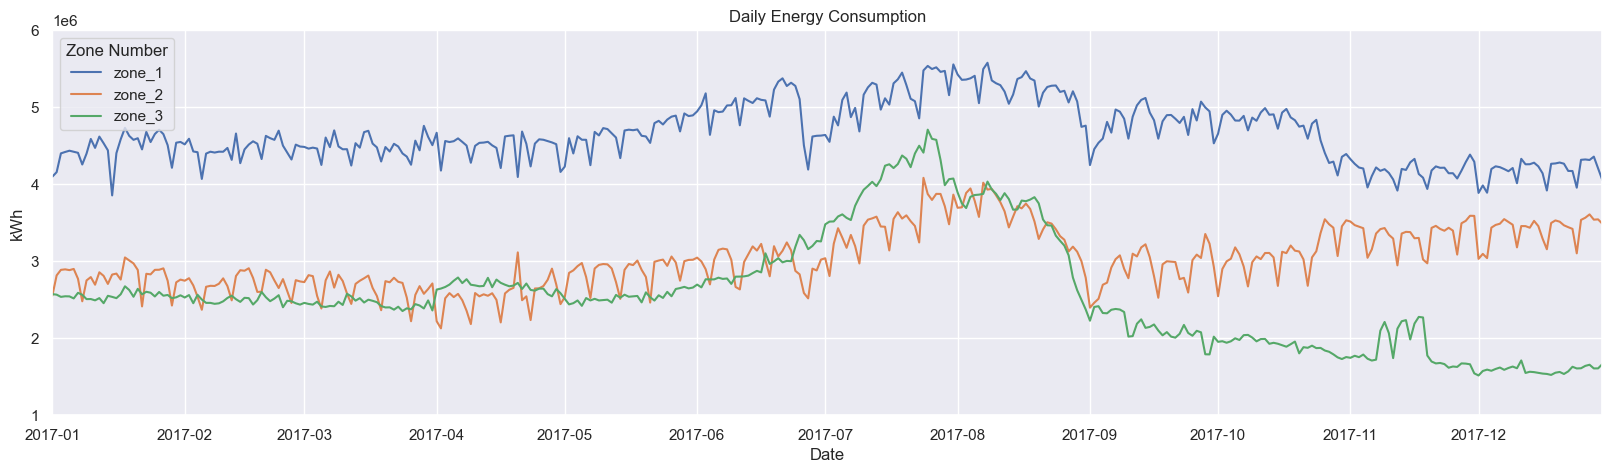

In [10]:
# Ploting all zones, consumptions against date
fig=plt.figure(figsize=(20,5))
plt.plot(data_zones_daily[['Zone_1_Power_Consumption']], label="zone_1")
plt.plot(data_zones_daily[['Zone_2_Power_Consumption']], label="zone_2")
plt.plot(data_zones_daily[['Zone_3_Power_Consumption']], label="zone_3")
plt.title('Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.ylim(1*1e6,6*1e6)
plt.xlim([dt.date(2017, 1, 1), dt.date(2017, 12, 30)])
plt.legend(title='Zone Number', loc='upper left')
plt.show()

#### Zone 1 and 2 has similar pattern with different mean. Both has stronger weekly pattern than zone 3. There less difference between differnet month in comparison to zone 3.

#### However, in Zone 3. There is not weekly pattern. In summer holidays, July and August, there is higher consumption in coparison to other month of year.


## Box plot Energy consumption weekday basis

In [12]:
z1 = data_zones_daily[["Zone_1_Power_Consumption", "weekday"]].reset_index(drop=True)
z1.columns = ['energy_consumption', 'weekday']
z1['zone'] = "zone_1"

z2 = data_zones_daily[["Zone_2_Power_Consumption", "weekday"]].reset_index(drop=True)
z2.columns = ['energy_consumption', 'weekday']
z2['zone'] = "zone_2"

z3 = data_zones_daily[["Zone_3_Power_Consumption", "weekday"]].reset_index(drop=True)
z3.columns = ['energy_consumption', 'weekday']
z3['zone'] = "zone_3"

data_zones_daily_long = pd.concat([z1, z2, z3], ignore_index=True)
data_zones_daily_long

,energy_consumption,weekday,zone
0,4.098993e+06,Sunday,zone_1
1,4.157207e+06,Monday,zone_1
2,4.400992e+06,Tuesday,zone_1
3,4.419336e+06,Wednesday,zone_1
4,4.435619e+06,Thursday,zone_1
...,...,...,...
1087,1.640978e+06,Tuesday,zone_3
1088,1.655752e+06,Wednesday,zone_3
1089,1.608052e+06,Thursday,zone_3
1090,1.608663e+06,Friday,zone_3


<AxesSubplot: xlabel='weekday', ylabel='energy_consumption'>

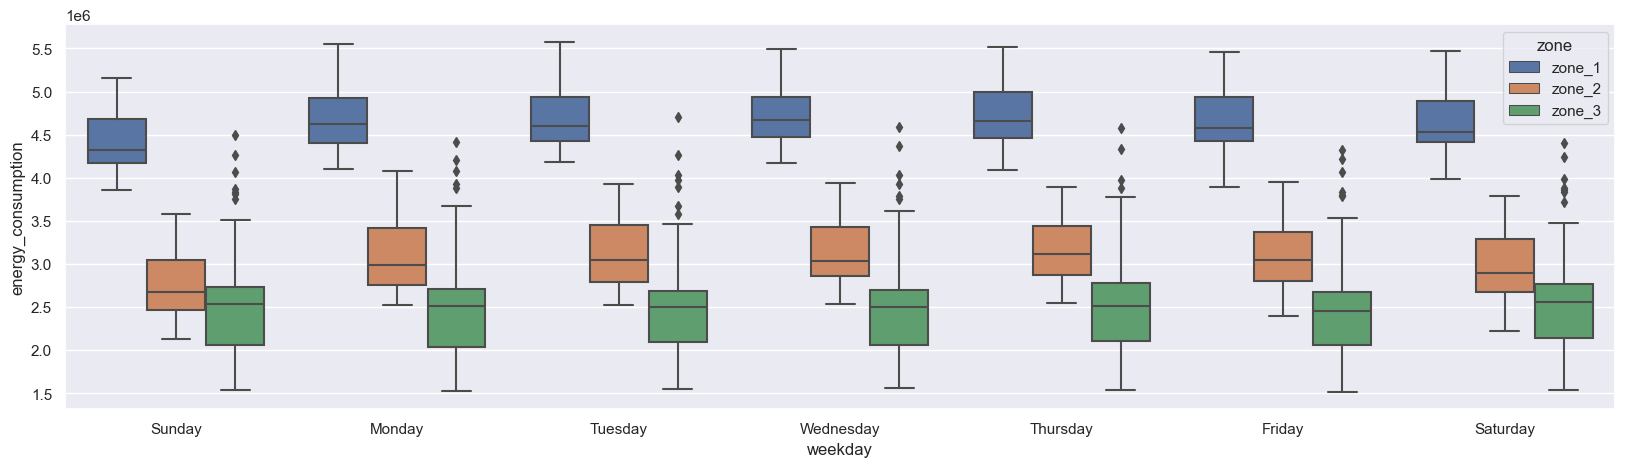

In [13]:
sns.set(rc={"figure.figsize":(20, 5)})
sns.boxplot(x="weekday", y="energy_consumption", hue="zone", data=data_zones_daily_long)

#### Zones has less consumption on Sundays compare to other week days. 

## Daily Energy Consumption vs. Temperature

In [14]:
data_zones = data_zones.resample('D').agg({'Temperature': np.mean, 
                                           'Zone_1_Power_Consumption': np.sum, 
                                           'Zone_2_Power_Consumption': np.sum,
                                           'Zone_3_Power_Consumption': np.sum})

data_zones['Temperature_int'] = data_zones.Temperature.astype('int64')
data_zones_temp = data_zones.groupby('Temperature_int').agg({'Zone_1_Power_Consumption': np.mean, 
                                                             'Zone_2_Power_Consumption': np.mean,
                                                             'Zone_3_Power_Consumption': np.mean}).reset_index()

data_zones['month'] = data_zones.index.month

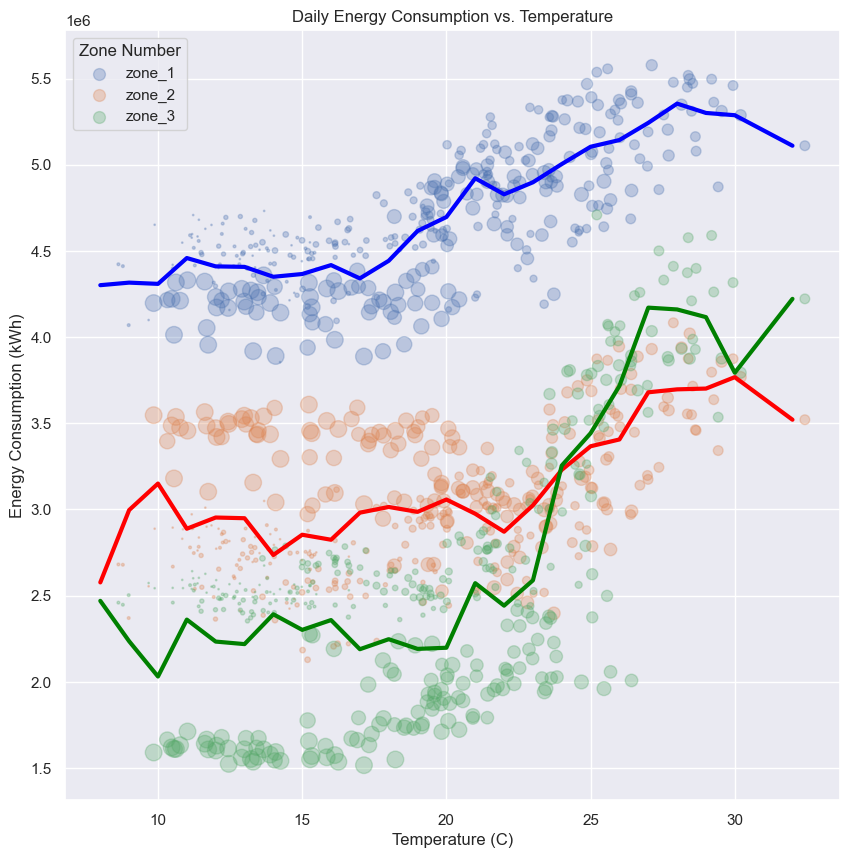

In [15]:
fig =plt.figure(figsize=(10,10))
plt.plot(data_zones_temp.Temperature_int, data_zones_temp["Zone_1_Power_Consumption"], color="blue", linewidth=3)
plt.plot(data_zones_temp.Temperature_int, data_zones_temp["Zone_2_Power_Consumption"], color="red", linewidth=3)
plt.plot(data_zones_temp.Temperature_int, data_zones_temp["Zone_3_Power_Consumption"], color="green", linewidth=3)

plt.scatter(data_zones.Temperature, data_zones.Zone_1_Power_Consumption, data_zones.month**2, alpha=0.3, label="zone_1")
plt.scatter(data_zones.Temperature, data_zones.Zone_2_Power_Consumption, data_zones.month**2, alpha=0.3, label="zone_2")
plt.scatter(data_zones.Temperature, data_zones.Zone_3_Power_Consumption, data_zones.month**2, alpha=0.3,  label="zone_3")

plt.title('Daily Energy Consumption vs. Temperature')
plt.xlabel('Temperature (C)')
plt.ylabel('Energy Consumption (kWh)')
plt.legend(title='Zone Number', loc='upper left')
plt.show()

#### Scatter plot of energy consumption vs. Tempreture and average trends of it. Energy consumption increases as Temprature rises mostly after 20'c.


## Heat Map of Energy consumption vs. Month

In [16]:
data_zones_monthly = data_zones.resample('M').agg({'Zone_1_Power_Consumption': np.mean, 
                                                   'Zone_2_Power_Consumption': np.mean,
                                                   'Zone_3_Power_Consumption': np.mean}).reset_index()
data_zones_monthly['Month'] = data_zones_monthly.DateTime.dt.month_name()
data_zones_monthly = data_zones_monthly.set_index('Month').drop(['DateTime'], axis=1)

<AxesSubplot:ylabel='Month'>

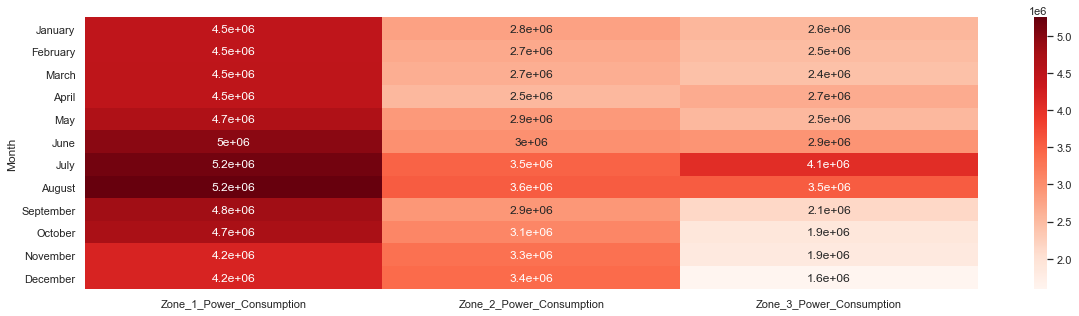

In [59]:
sns.heatmap(data=data_zones_monthly, annot=True, cmap="Reds")

#### Based on the observations, zone 1 is picked for further investigation and doing the prediction. Zone 1 has higher amount of consumption. It has more constant behaviour during year. It has a weekly pattern. All makes it better candidate for modelling.

# Zone 1
## Power consumption vs. time plot

In [18]:
data_zone1 = data[['Zone_1_Power_Consumption']]
# Changing frequency to daily
data_zone1 = data_zone1.resample('D').sum()

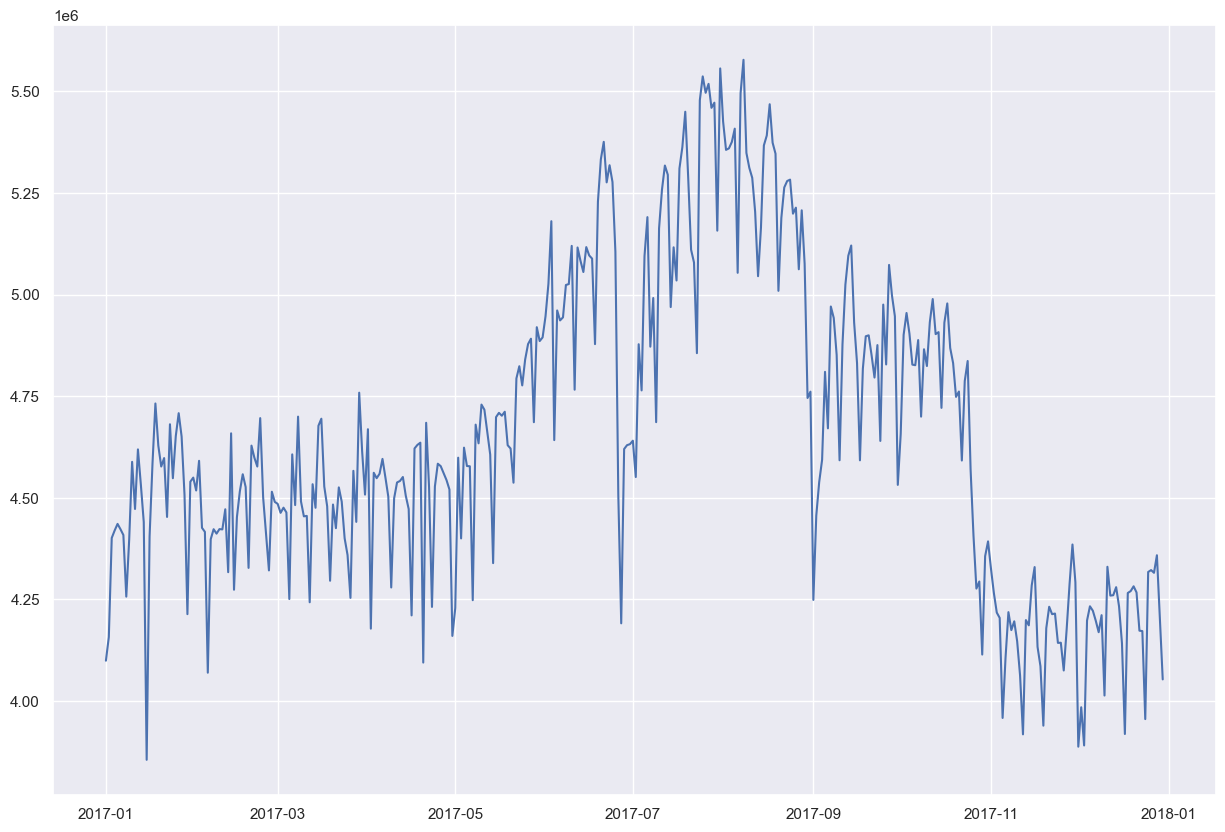

In [19]:
fig =plt.figure(figsize=(15,10))
plt.plot(data_zone1)

In [23]:
# # Save as a new csv file
# data_zone1.to_csv('data_zone1.csv')

## Monthly Box plot

In [20]:
data_zone1['weekday'] = data_zone1.index.day_name()
data_zone1['month'] = data_zone1.index.month_name()

<AxesSubplot: xlabel='month', ylabel='Zone_1_Power_Consumption'>

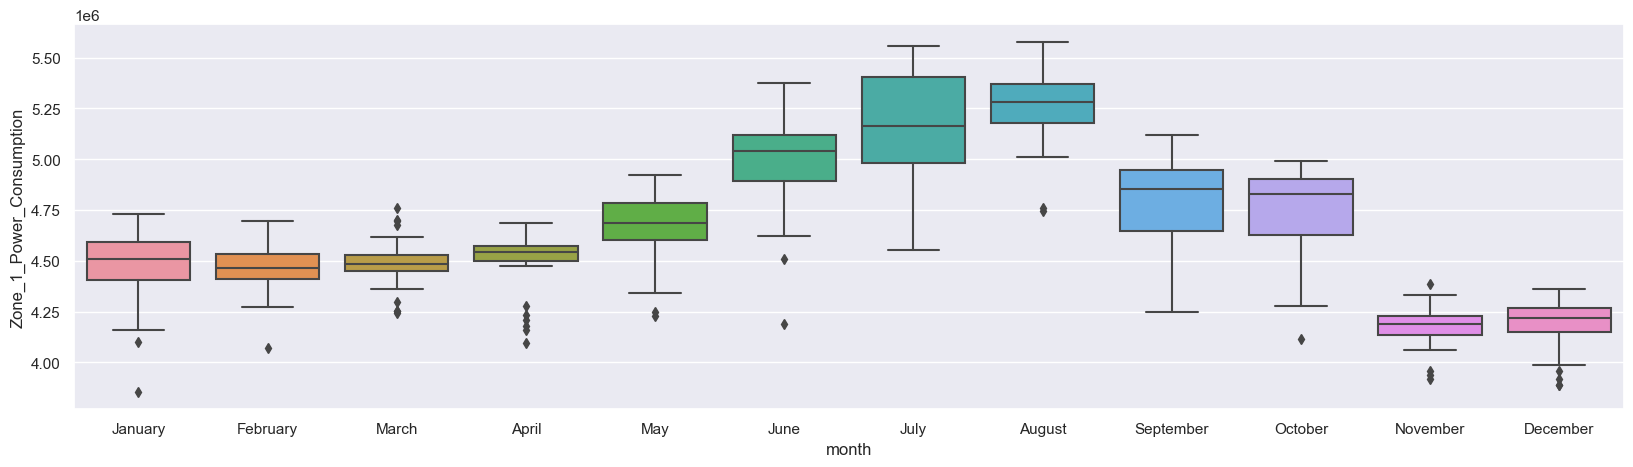

In [21]:
sns.set(rc={"figure.figsize":(20, 5)}) #width=8, height=4
sns.boxplot(x="month", y="Zone_1_Power_Consumption", data=data_zone1)

## Daily pattern plot

<AxesSubplot: xlabel='time'>

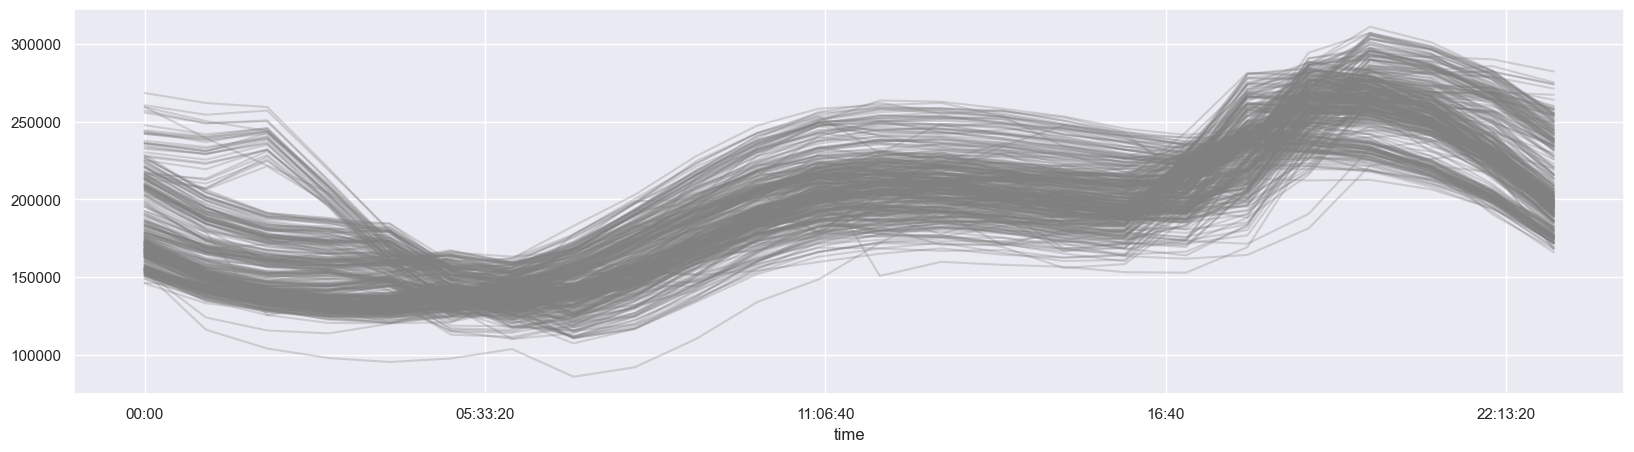

In [27]:
data_zone1_hourly = data[['Zone_1_Power_Consumption']]
data_zone1_hourly = data_zone1_hourly.resample('H').sum()

data_zone1_hourly['weekday'] = data_zone1_hourly.index.day_name()
data_zone1_hourly['time'] = data_zone1_hourly.index.time
data_zone1_hourly['date'] = data_zone1_hourly.index.date

data_zone1_hourly_pivot = pd.pivot_table(data_zone1_hourly, values='Zone_1_Power_Consumption', index='time', columns='date')
data_zone1_hourly_pivot.plot(color="grey", legend=False, alpha = 0.3)